<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Create your first trading strategy

### Summary
* Manage the data
* Moving average
* Strategy
* Graph
* Compute the profit
* Automatization
* Compare strategy on data which come from different sources

<br>


💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Manage the data


In [ ]:
# Preprocessing function

def preprocessing(name):
  
  # Import the data
  df = pd.read_csv(name, delimiter="\t", index_col="<DATE>", parse_dates=True)

  # Delete the two last columns
  df = df.iloc[:,:-2]

  # Rename
  df.columns = ["open", "high", "low", "close", "volume"]
  df.index.name = "time"

  return df

In [ ]:
def preprocessing_yf(symbol):
  
  #Import the data
  df = yf.download("EURUSD=X").dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df

df = preprocessing_yf("EURUSD=X")
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0
...,...,...,...,...,...
2022-01-17,1.141214,1.143458,1.139315,1.141070,0
2022-01-18,1.141292,1.142335,1.132965,1.141057,0
2022-01-19,1.133003,1.135680,1.131952,1.132965,0


# Moving average

In [ ]:
# Create Simple moving average 30 days
df["SMA fast"] = df["close"].rolling(30).mean()

# Create Simple moving average 60 days
df["SMA slow"] = df["close"].rolling(60).mean()

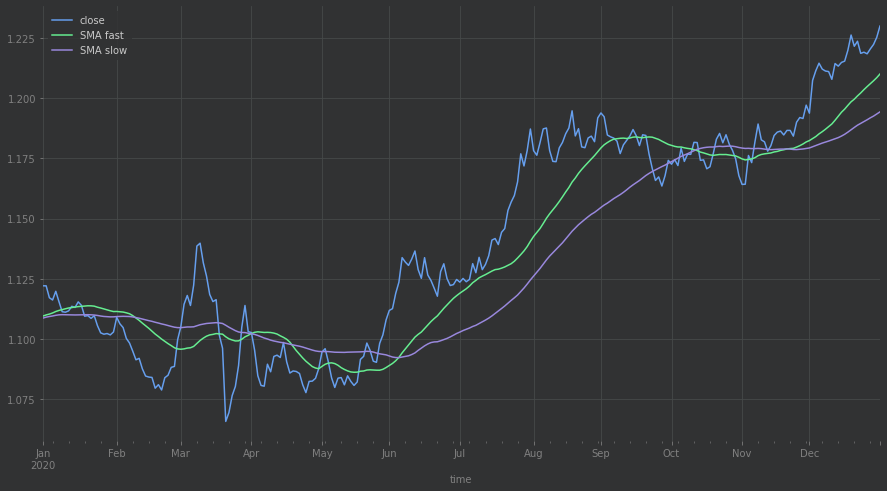

In [ ]:
# Plot the results
df[["close", "SMA fast", "SMA slow"]].loc["2020"].plot(figsize=(15,8))

# Strategy

In [ ]:
df["position"]=np.nan

# Create the condition
df.loc[(df["SMA fast"] > df["SMA slow"]), "position"] = 1
df.loc[(df["SMA fast"] < df["SMA slow"]), "position"] = -1

# Verification Graph

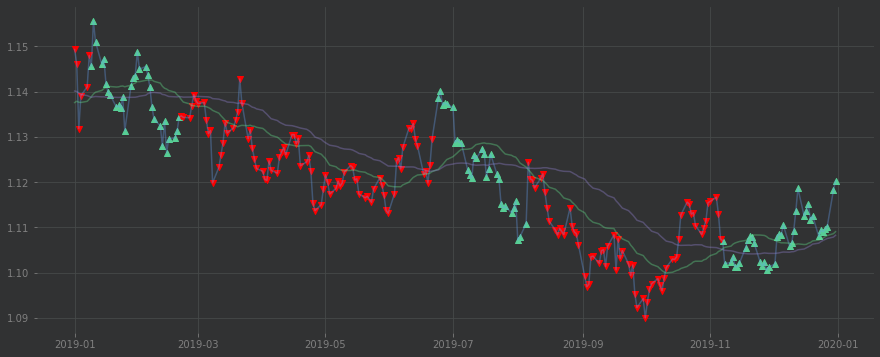

In [ ]:
# We plot all the signla to be sure that they be correct

year="2019"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["position"] == 1].loc[year].index
idx_close = df.loc[df["position"] == -1].loc[year].index



# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the open long signal in green and sell in red
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["close"].loc[year], color= "red", marker="v")


# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA fast"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA slow"].loc[year], alpha=0.35)



# Show the graph
plt.show()

# Compute the profit

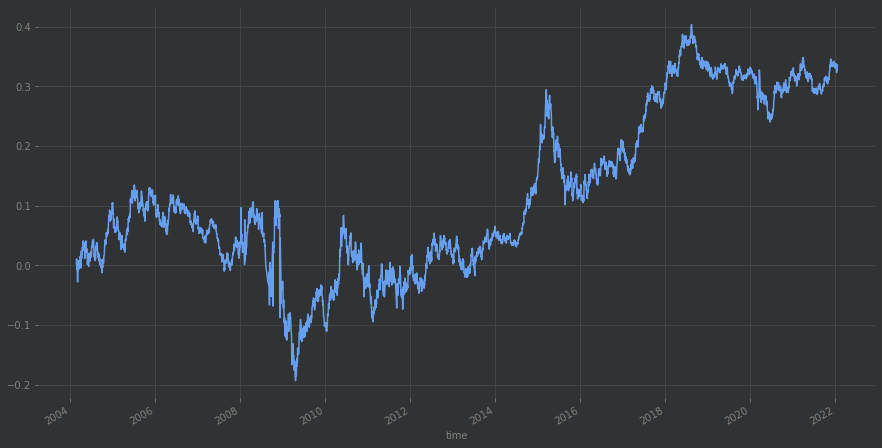

In [ ]:
# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = df["pct"] * df["position"].shift(1)


df["return"].cumsum().plot(figsize=(15,8))

In [ ]:
# (1%, 3%, -1%, -2%, 2%, 3%) -- > (1%, 4%, 3%, 1%, 3%, 6%)

# Automatization

In [ ]:
def SMA_strategy(input, mt5=False, yf=False):

  if mt5:
    df = preprocessing(input)
  
  if yf:
    df = preprocessing_yf(input)

  
  # Create Resistance using a rolling max
  df["SMA fast"] = df["close"].rolling(30).mean()

  # Create Support using a rolling min
  df["SMA slow"] = df["close"].rolling(60).mean()

  df["position"] = np.nan

  # Create the condition
  df.loc[(df["SMA fast"] > df["SMA slow"]) , "position"] = 1
  df.loc[(df["SMA fast"] < df["SMA slow"]) , "position"] = -1

  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy

  df["return"] = df["pct"] * (df["position"].shift(1))
  

  return df["return"]

[*********************100%***********************]  1 of 1 completed


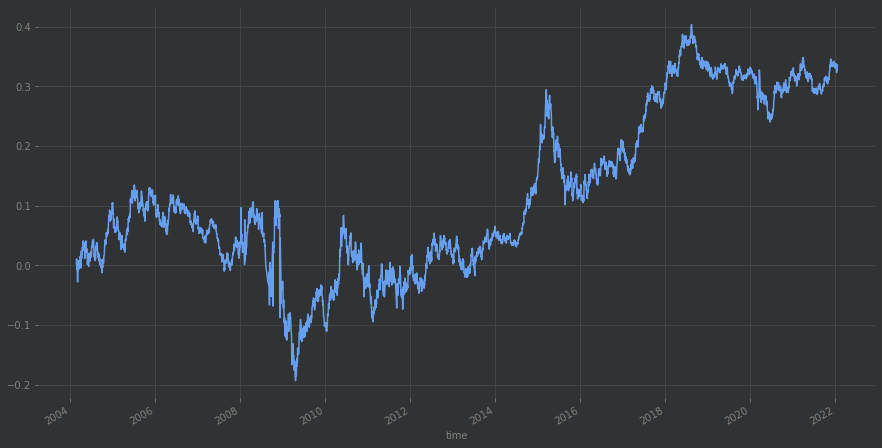

In [ ]:
SMA_strategy("EURUSD=X", yf=True).cumsum().plot(figsize=(15,8))

# Compare the strategy on different data

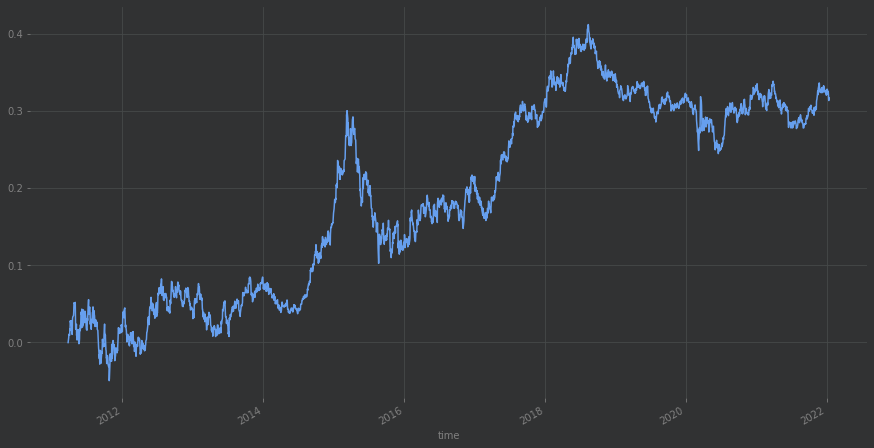

In [ ]:
SMA_strategy("EURUSD_D1.csv", mt5=True).cumsum().plot(figsize=(15,8))

[*********************100%***********************]  1 of 1 completed


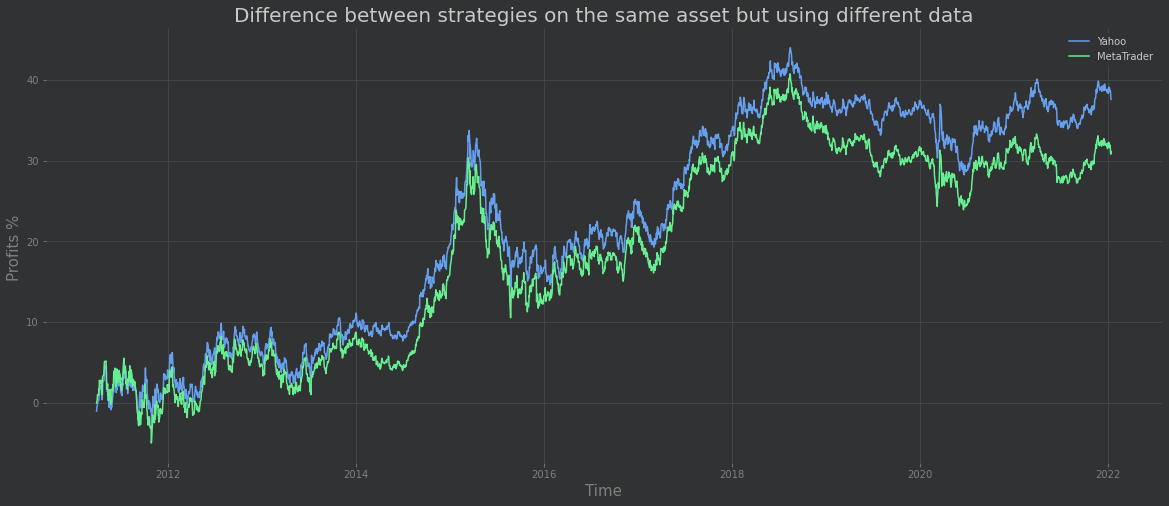

In [ ]:
# Same strategy but with different assets
yahoo = SMA_strategy("EURUSD=X", yf=True)
metatrader = SMA_strategy("EURUSD_D1.csv", mt5=True)

returns = pd.DataFrame([yahoo, metatrader], index=["Yahoo",
                                                   "Broker"]).transpose().dropna().cumsum(axis=0)

# Plot on graph

# Adapt the size
plt.figure(figsize=(20,8))

# Plot the returns
plt.plot(returns["Yahoo"]*100, label="Yahoo")
plt.plot(returns["Broker"]*100, label="MetaTrader")

# Plot title + name axis 
plt.xlabel("Time", size=15)
plt.ylabel("Profits % ", size=15)
plt.title("Difference between strategies on the same asset but using different data", size=20)


# Plot legend 
plt.legend()
plt.show()